In [32]:
import numpy as np
import pandas as pd
import pyflux as pf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as st
%matplotlib inline

In [2]:
bj_aq_last_day_orig = pd.read_csv("timely_data/\
bj_airquality_2018-3-27-0-2018-4-30-0.csv")
ld_aq_last_day_orig = pd.read_csv("timely_data/\
ld_airquality_2018-3-27-0-2018-4-30-0.csv")

In [3]:
def str_to_date(string):
    from datetime import datetime
    if "-" in string:
        date = datetime.strptime(string, "%Y-%m-%d %H:%M:%S")
    elif "/" in string:
         date = datetime.strptime(string, "%Y/%m/%d %H:%M:%S")
    return date

In [4]:
def perprocessing(df):
    df = df.fillna(10) # fill the nan in the df
    df["time"] = df["time"].apply(lambda x : 
                                  str_to_date(x)) # change the type of the date
    return df

In [5]:
aq = {"bj":perprocessing(bj_aq_last_day_orig),"ld":perprocessing(ld_aq_last_day_orig)}
sample = pd.read_csv("sample_submission.csv")
station_list = sample["test_id"].apply(lambda x : x.split("#")[0]).unique()
stations = {"bj": list(station_list[:35]),"ld": list(station_list[36:]) }
pollutes = {"bj":["PM25","PM10","03"], "ld":["PM25","PM10"]}


In [6]:
stations_aq = {}
for city in ["bj","ld"]:
    for station in stations[city]:
        city_aq = aq[city]
        station_aq = city_aq[city_aq["station_id"] == station]
        if city == "bj":
            stations_aq[station] = pd.DataFrame({
                "time" : station_aq["time"].values,
                "PM25" : station_aq["PM25_Concentration"].values,
                "PM10" : station_aq["PM10_Concentration"].values,
                "O3":station_aq["O3_Concentration"].values

            })
        else :
            stations_aq[station] = pd.DataFrame({
                "time" : station_aq["time"].values,
                "PM25" : station_aq["PM25_Concentration"].values,
                "PM10" : station_aq["PM10_Concentration"].values,
            })
            

In [9]:
def predict_48h(station, pollution):
    model = pf.ARIMA(data = stations_aq[station], ar=12, integ=0, ma=12,target=pollution,family=pf.Normal())
    fitness = model.fit("MLE")
    predicts = model.predict(h = 48)
    return predicts

In [31]:
"""csvs = {}
i = 0
for station in stations["bj"]:
    predicts_PM_25 = predict_48h(station, "PM25")["PM25"].values
    predicts_PM_10 = predict_48h(station, "PM10")["PM10"].values
    predicts_O_3 = predict_48h(station, "O3")["O3"].values

    csv = pd.DataFrame({"PM2.5" : predicts_PM_25, 
                        "PM10" : predicts_PM_10,
                        "O3" : predicts_O_3})
    csv.index = [station+"#"+str(i)  for i in range(len(csv))]
    if i == 0:
        csvs = csv
    else:
        csvs = pd.concat([csvs, csv],axis = 1)
    i += 1"""

'csvs = {}\ni = 0\nfor station in stations["bj"]:\n    predicts_PM_25 = predict_48h(station, "PM25")["PM25"].values\n    predicts_PM_10 = predict_48h(station, "PM10")["PM10"].values\n    predicts_O_3 = predict_48h(station, "O3")["O3"].values\n\n    csv = pd.DataFrame({"PM2.5" : predicts_PM_25, \n                        "PM10" : predicts_PM_10,\n                        "O3" : predicts_O_3})\n    csv.index = [station+"#"+str(i)  for i in range(len(csv))]\n    if i == 0:\n        csvs = csv\n    else:\n        csvs = pd.concat([csvs, csv],axis = 1)\n    i += 1'

In [35]:
target_series = stations_aq["dongsihuan_aq"]["PM25"]

In [43]:
type(target_series)

pandas.core.series.Series

In [39]:
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1]

In [40]:
test_stationarity(target_series)

0.0026470158639469651

In [46]:
target_series

0       97.0
1       96.0
2       97.0
3      103.0
4      120.0
5      137.0
6      143.0
7      152.0
8      154.0
9      165.0
10     175.0
11     181.0
12     177.0
13     175.0
14     201.0
15     227.0
16     287.0
17     288.0
18     272.0
19     273.0
20     263.0
21     150.0
22     109.0
23      94.0
24      80.0
25      92.0
26     131.0
27     143.0
28     170.0
29     211.0
       ...  
631    248.0
632    264.0
633    254.0
634    254.0
635    259.0
636    255.0
637    242.0
638    200.0
639     92.0
640     98.0
641    115.0
642    104.0
643     85.0
644     73.0
645     74.0
646     94.0
647     99.0
648     99.0
649    101.0
650     98.0
651    100.0
652     97.0
653     41.0
654     16.0
655     16.0
656     12.0
657     11.0
658     12.0
659     13.0
660     18.0
Name: PM25, Length: 661, dtype: float64

In [41]:
def choose_order(ts, maxar, maxma):
    order = st.arma_order_select_ic(ts, maxar, maxma, ic=['aic', 'bic', 'hqic'])
    return order.bic_min_order

In [ ]:
choose_order(target_series.values, 40,40)

In [36]:
test_stationarity(target_series)

0.0026470158639469651

In [ ]:
csvs.head()

In [33]:
stations_aq["dongsihuan_aq"]["PM25"]

0       97.0
1       96.0
2       97.0
3      103.0
4      120.0
5      137.0
6      143.0
7      152.0
8      154.0
9      165.0
10     175.0
11     181.0
12     177.0
13     175.0
14     201.0
15     227.0
16     287.0
17     288.0
18     272.0
19     273.0
20     263.0
21     150.0
22     109.0
23      94.0
24      80.0
25      92.0
26     131.0
27     143.0
28     170.0
29     211.0
       ...  
631    248.0
632    264.0
633    254.0
634    254.0
635    259.0
636    255.0
637    242.0
638    200.0
639     92.0
640     98.0
641    115.0
642    104.0
643     85.0
644     73.0
645     74.0
646     94.0
647     99.0
648     99.0
649    101.0
650     98.0
651    100.0
652     97.0
653     41.0
654     16.0
655     16.0
656     12.0
657     11.0
658     12.0
659     13.0
660     18.0
Name: PM25, Length: 661, dtype: float64

In [15]:
def mmmodel(ar, ma, integ):
    model = pf.ARIMA(data = stations_aq["dongsihuan_aq"], ar=ar, integ=0, ma=ma,target="PM25",family=pf.Normal())
    x = model.fit(integ)
    x.summary()
    model.plot_fit()
    model.plot_predict(h=24,past_values=10)
    b = model.predict(h=24) 
    # model.plot_predict_is(h=48)
    return b

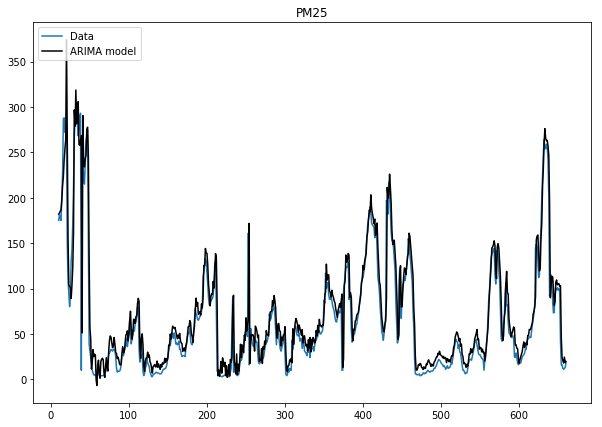

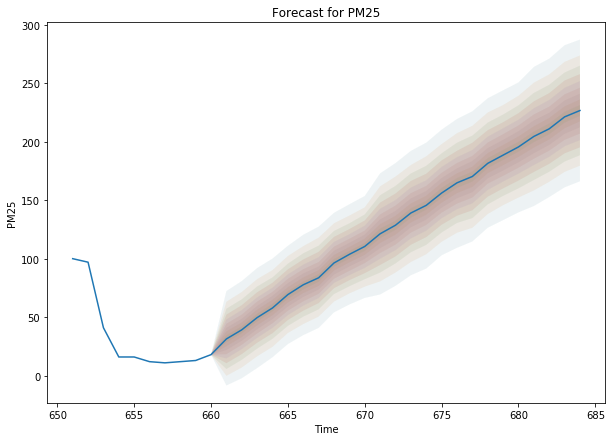

In [24]:
model = pf.ARIMA(data = stations_aq["dongsihuan_aq"], ar=10, integ=0, ma=10,target="PM25",family=pf.Normal())
x = model.fit("PML")
# x.summary()
model.plot_fit()
model.plot_predict(h=24,past_values=10)
# b = model.predict(h=24) 

Normal ARIMA(2,0,48)                                                                                      
======================================================= ==================================================
Dependent Variable: PM25                                Method: PML                                       
Start Date: 48                                          Unnormalized Log Posterior: -2973.5733            
End Date: 660                                           AIC: 6051.1466                                    
Number of observations: 613                             BIC: 6280.9016                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 65.2819    3.8842     16.8069  0.0      (57.6688 | 72.895)       
AR(1)                                

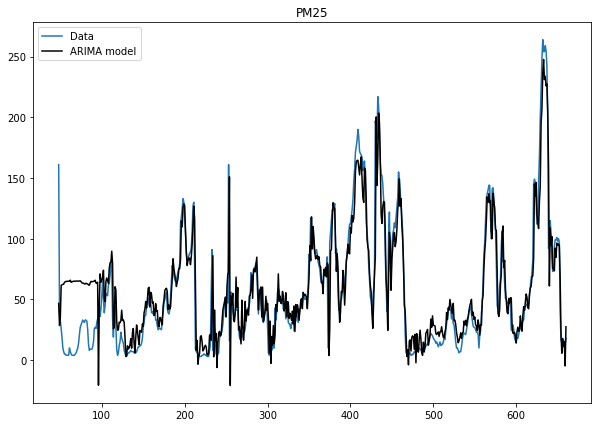

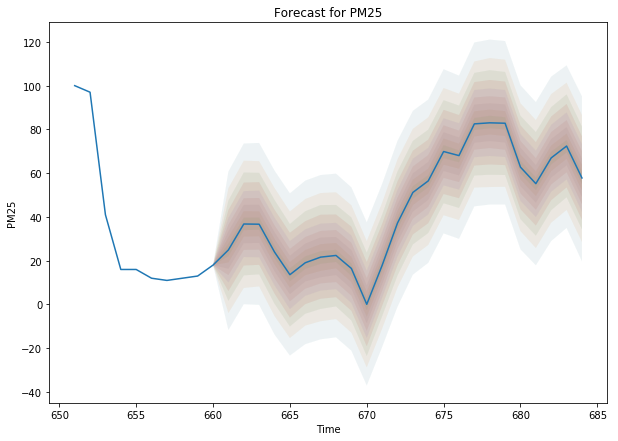

,PM25
661,24.930673
662,36.776947
663,36.682676
664,23.962946
665,13.617927
666,19.073445
667,21.640539
668,22.406957
669,16.464478
670,0.082378


In [30]:
mmmodel(2,48,'PML')